### In this notebook, we will try to predict the electric motor's temperature, given its current state like motor speed, coolant temperature etc. Hope you enjoy going through the notebook!

In [1]:
# Importing libraries
from scipy import stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures as PF
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error as mse

sns.set()

In [2]:
# Function to visualize a variable - Histogram, Boxplot, Q-Q Plot
def plot_variable(series):
    # Histogram
    sns.displot(series, kde=True)
    plt.show()
    
    # Boxplot
    sns.boxplot(x=series)
    plt.show()
    
    # Q-Q Plot
    stats.probplot(series, plot=plt)
    plt.show()

In [3]:
# Importing dataset
dataset = pd.read_csv('../input/electric-motor-temperature/measures_v2.csv')

In [4]:
# Taking a backup of the dataset
dataset_copy = dataset.copy()

In [5]:
# First 5 rows
dataset.head()

,u_q,coolant,stator_winding,u_d,stator_tooth,motor_speed,i_d,i_q,pm,stator_yoke,ambient,torque,profile_id
0,-0.450682,18.805172,19.086670,-0.350055,18.293219,0.002866,0.004419,0.000328,24.554214,18.316547,19.850691,0.187101,17
1,-0.325737,18.818571,19.092390,-0.305803,18.294807,0.000257,0.000606,-0.000785,24.538078,18.314955,19.850672,0.245417,17
2,-0.440864,18.828770,19.089380,-0.372503,18.294094,0.002355,0.001290,0.000386,24.544693,18.326307,19.850657,0.176615,17
3,-0.327026,18.835567,19.083031,-0.316199,18.292542,0.006105,0.000026,0.002046,24.554018,18.330833,19.850647,0.238303,17
4,-0.471150,18.857033,19.082525,-0.332272,18.291428,0.003133,-0.064317,0.037184,24.565397,18.326662,19.850639,0.208197,17


In [6]:
# No. of rows and columns
dataset.shape

(1330816, 13)

In [7]:
# Dataset columns
dataset.columns

Index(['u_q', 'coolant', 'stator_winding', 'u_d', 'stator_tooth',
       'motor_speed', 'i_d', 'i_q', 'pm', 'stator_yoke', 'ambient', 'torque',
       'profile_id'],
      dtype='object')

In [8]:
# Renaming columns for convenience
dataset = dataset.rename(columns={'u_q': 'q_voltage', 'coolant': 'coolant_temp', 'stator_winding': 'stator_winding_temp',
                                  'u_d': 'd_voltage', 'stator_tooth': 'stator_tooth_temp', 'i_d': 'd_component_measure',
                                  'i_q': 'q_component_measure', 'pm': 'em_temp', 'stator_yoke': 'stator_yoke_temp',
                                  'ambient': 'ambient_temp'})

In [9]:
# Dataset columns after renaming
dataset.columns

Index(['q_voltage', 'coolant_temp', 'stator_winding_temp', 'd_voltage',
       'stator_tooth_temp', 'motor_speed', 'd_component_measure',
       'q_component_measure', 'em_temp', 'stator_yoke_temp', 'ambient_temp',
       'torque', 'profile_id'],
      dtype='object')

In [10]:
# Rearranging columns in order: Target, Features
dataset = dataset[['em_temp', 'profile_id', 'q_voltage', 'coolant_temp', 'stator_winding_temp', 'd_voltage',
                   'stator_tooth_temp', 'motor_speed', 'd_component_measure', 'q_component_measure', 'stator_yoke_temp',
                   'ambient_temp', 'torque']]

In [11]:
# Deleting ID column as it provides no useful statistics or help in predicting the electric motor temperature
dataset = dataset.drop(columns=['profile_id'])

In [12]:
# Dataset columns after rearrangement
dataset.columns

Index(['em_temp', 'q_voltage', 'coolant_temp', 'stator_winding_temp',
       'd_voltage', 'stator_tooth_temp', 'motor_speed', 'd_component_measure',
       'q_component_measure', 'stator_yoke_temp', 'ambient_temp', 'torque'],
      dtype='object')

In [13]:
# First 5 rows
dataset.head()

,em_temp,q_voltage,coolant_temp,stator_winding_temp,d_voltage,stator_tooth_temp,motor_speed,d_component_measure,q_component_measure,stator_yoke_temp,ambient_temp,torque
0,24.554214,-0.450682,18.805172,19.086670,-0.350055,18.293219,0.002866,0.004419,0.000328,18.316547,19.850691,0.187101
1,24.538078,-0.325737,18.818571,19.092390,-0.305803,18.294807,0.000257,0.000606,-0.000785,18.314955,19.850672,0.245417
2,24.544693,-0.440864,18.828770,19.089380,-0.372503,18.294094,0.002355,0.001290,0.000386,18.326307,19.850657,0.176615
3,24.554018,-0.327026,18.835567,19.083031,-0.316199,18.292542,0.006105,0.000026,0.002046,18.330833,19.850647,0.238303
4,24.565397,-0.471150,18.857033,19.082525,-0.332272,18.291428,0.003133,-0.064317,0.037184,18.326662,19.850639,0.208197


In [14]:
# Last 5 rows
dataset.tail()

,em_temp,q_voltage,coolant_temp,stator_winding_temp,d_voltage,stator_tooth_temp,motor_speed,d_component_measure,q_component_measure,stator_yoke_temp,ambient_temp,torque
1330811,62.147780,-2.152128,30.721298,45.274497,0.791801,41.934347,0.000380,-2.000169,1.097528,38.653720,23.989078,-8.116730e-60
1330812,62.142646,-2.258684,30.721306,45.239017,0.778900,41.868923,0.002985,-2.000499,1.097569,38.656328,23.970700,-5.815891e-60
1330813,62.138387,-2.130312,30.721312,45.211576,0.804914,41.804819,0.002301,-1.999268,1.098765,38.650923,23.977234,-4.167268e-60
1330814,62.133422,-2.268498,30.721316,45.193508,0.763091,41.762220,0.005662,-2.000999,1.095696,38.655686,24.001421,-2.985978e-60
1330815,62.131429,-2.100158,30.721319,45.132307,0.807309,41.734763,0.004395,-2.000792,1.096487,38.660370,24.027522,-2.139547e-60


In [15]:
# 10 random rows
dataset.sample(10)

,em_temp,q_voltage,coolant_temp,stator_winding_temp,d_voltage,stator_tooth_temp,motor_speed,d_component_measure,q_component_measure,stator_yoke_temp,ambient_temp,torque
1091788,64.887605,-2.072821,90.899629,86.118924,0.114945,84.821181,0.000202,-2.001161,1.096768,85.591018,25.608160,-3.705492e-320
600087,38.837807,37.099186,18.624157,23.578127,-0.083844,23.205137,749.988098,-2.000100,1.096924,21.473179,24.362259,2.462644e-01
652516,42.728682,128.397066,23.777162,75.994728,-21.353565,58.973341,4077.001753,-72.453688,12.206434,43.377936,23.766426,9.299780e+00
1292812,81.537229,131.073918,81.485170,86.896388,-13.689157,85.967462,2977.327375,-10.458468,12.016169,83.512120,28.971410,7.921447e+00
813841,74.571302,27.445530,56.093381,90.146410,0.112327,80.539039,590.212483,-3.718559,7.142130,70.435432,26.384510,4.045114e+00
1036050,36.212736,1.077847,28.196006,28.413062,0.410810,27.749355,-0.003856,-2.001322,1.096369,27.216031,23.980595,-3.705492e-320
1016746,62.445094,1.226764,42.410443,43.418759,1.853740,42.770276,0.001022,-2.000654,1.096879,41.932759,25.582613,3.705492e-320
149588,34.434750,23.683397,19.089989,39.458530,-22.029522,32.676308,499.990326,-43.512802,132.617142,27.436853,23.101997,1.032347e+02
156596,33.719681,24.786547,18.552326,23.929323,0.194619,23.170357,499.994263,-2.000068,1.097520,21.489208,22.200031,1.554030e-01
1119475,58.091821,-0.862881,45.608013,45.790168,-0.666693,44.894199,-0.003583,-2.000551,1.096312,44.460907,25.801746,3.705492e-320


In [16]:
# Count of NaN values
dataset.isnull().sum()

em_temp                0
q_voltage              0
coolant_temp           0
stator_winding_temp    0
d_voltage              0
stator_tooth_temp      0
motor_speed            0
d_component_measure    0
q_component_measure    0
stator_yoke_temp       0
ambient_temp           0
torque                 0
dtype: int64

There are no missing values.

In [17]:
# Checking if duplicate rows are present
dataset.duplicated().sum()

0

There are no duplicate rows.

In [18]:
# Descriptive statistics
dataset.describe().round(2)

,em_temp,q_voltage,coolant_temp,stator_winding_temp,d_voltage,stator_tooth_temp,motor_speed,d_component_measure,q_component_measure,stator_yoke_temp,ambient_temp,torque
count,1330816.00,1330816.00,1330816.00,1330816.00,1330816.00,1330816.00,1330816.00,1330816.00,1330816.00,1330816.00,1330816.00,1330816.00
mean,58.51,54.28,36.23,66.34,-25.13,56.88,2202.08,-68.72,37.41,48.19,24.57,31.11
std,19.00,44.17,21.79,28.67,63.09,22.95,1859.66,64.93,92.18,19.99,1.93,77.14
min,20.86,-25.29,10.62,18.59,-131.53,18.13,-275.55,-278.00,-293.43,18.08,8.78,-246.47
25%,43.15,12.07,18.70,42.79,-78.69,38.42,317.11,-115.41,1.10,31.99,23.18,-0.14
50%,60.27,48.94,26.90,65.11,-7.43,56.04,1999.98,-51.09,15.77,45.63,24.80,10.86
75%,72.01,90.03,49.86,88.14,1.47,75.59,3760.64,-2.98,100.61,61.46,26.22,91.60
max,113.61,133.04,101.60,141.36,131.47,111.95,6000.02,0.05,301.71,101.15,30.71,261.01


Observation: All variables are continuous.

Note: The target is represented by the "em_temp" variable.

In [19]:
# Number of rows and columns in the dataset now
dataset.shape

(1330816, 12)

In [20]:
# Measuring skewness of variables
dataset.skew()

em_temp                0.038312
q_voltage              0.314933
coolant_temp           1.048115
stator_winding_temp    0.167666
d_voltage              0.145061
stator_tooth_temp      0.137610
motor_speed            0.386464
d_component_measure   -0.707305
q_component_measure   -0.146505
stator_yoke_temp       0.481009
ambient_temp          -0.349066
torque                -0.127141
dtype: float64

Observations:
1. Coolant temperature feature is highly right skewed.
2. d-component measurement feature is moderately left skewed.
3. All other features are following a normal distribution.

### Data Visualization

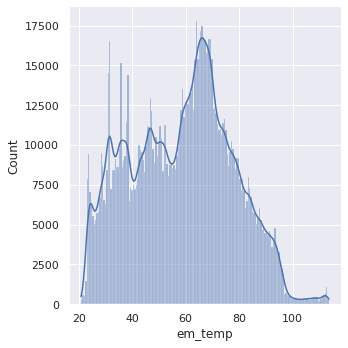

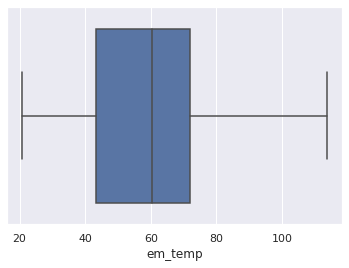

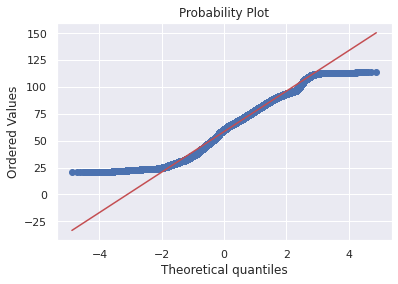

In [21]:
# Electric motor temperature
plot_variable(dataset['em_temp'])

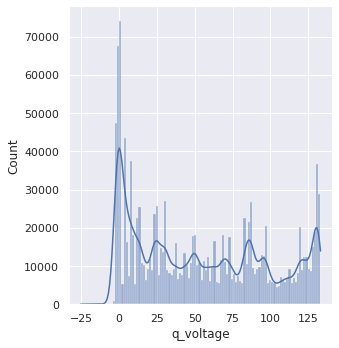

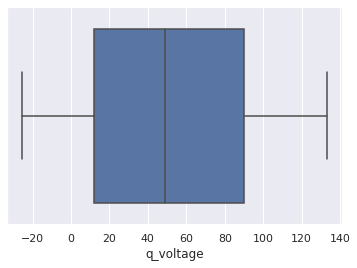

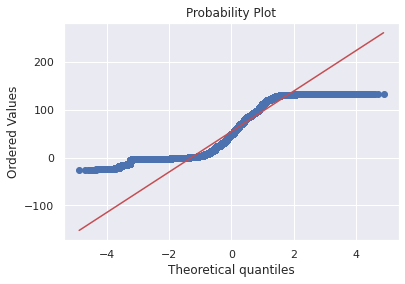

In [22]:
# q-component voltage
plot_variable(dataset['q_voltage'])

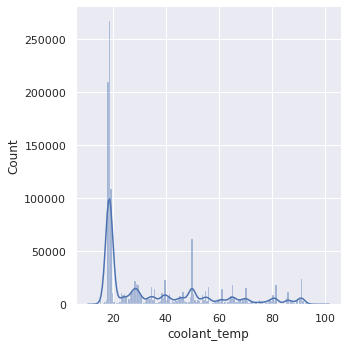

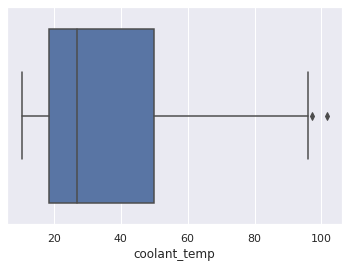

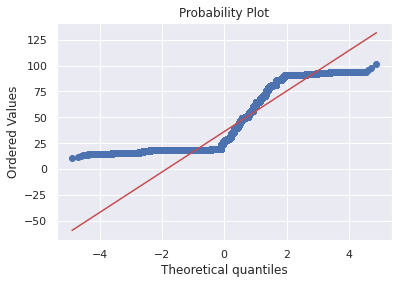

In [23]:
# Coolant temperature
plot_variable(dataset['coolant_temp'])

As the coolant temperature feature is highly right skewed, we will reduce the skewness.

In [24]:
# Applying box-cox transformation
dataset['coolant_temp'] = stats.boxcox(dataset['coolant_temp'])[0]

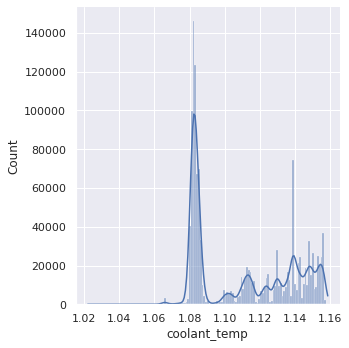

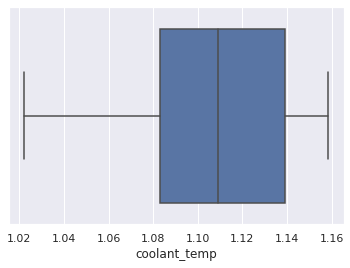

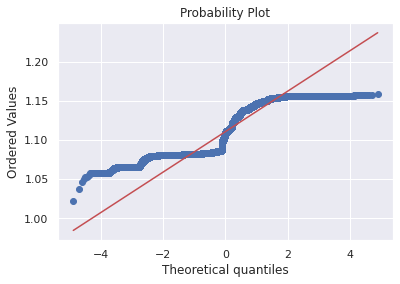

In [25]:
# Visualizing after transformation
plot_variable(dataset['coolant_temp'])

After transformation, the coolant temperature feature is now normally distributed.

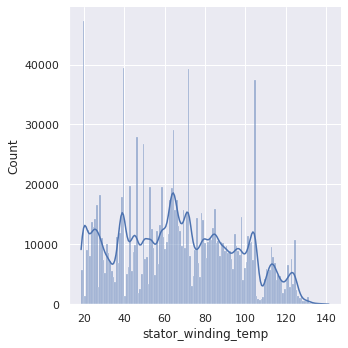

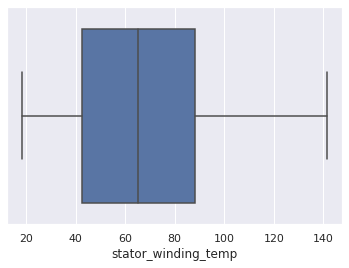

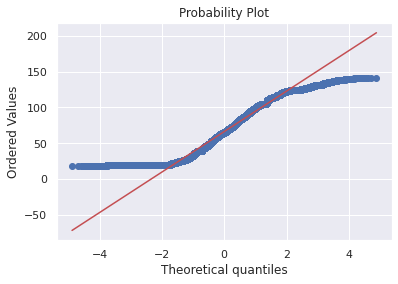

In [26]:
# Stator winding temperature
plot_variable(dataset['stator_winding_temp'])

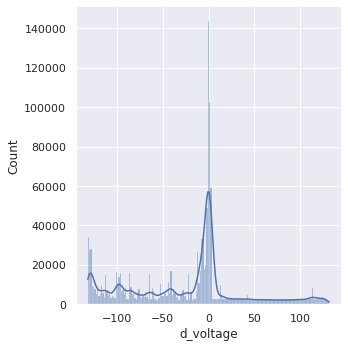

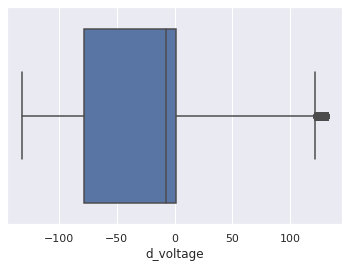

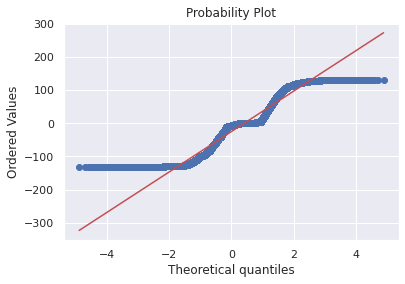

In [27]:
# d-component voltage
plot_variable(dataset['d_voltage'])

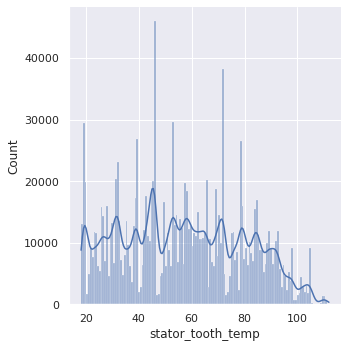

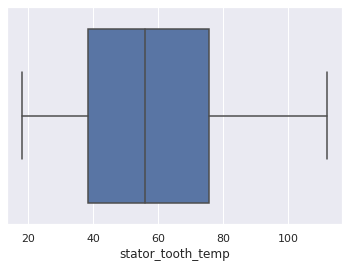

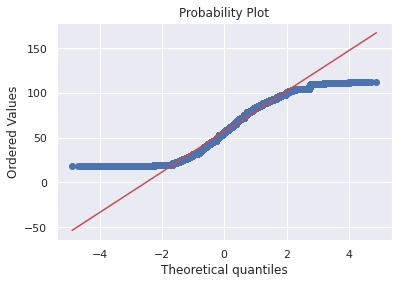

In [28]:
# Stator tooth temperature
plot_variable(dataset['stator_tooth_temp'])

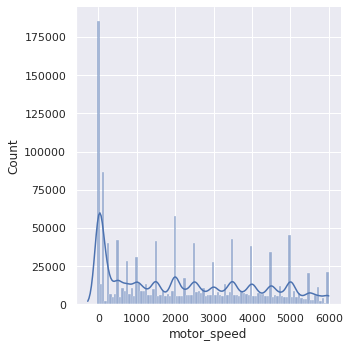

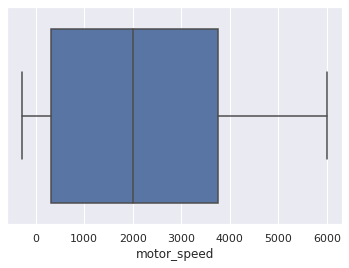

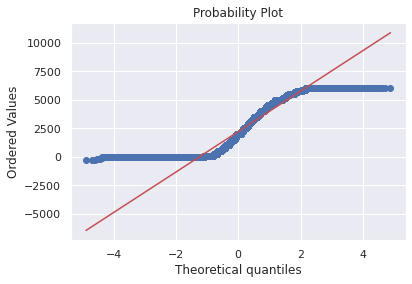

In [29]:
# Motor speed
plot_variable(dataset['motor_speed'])

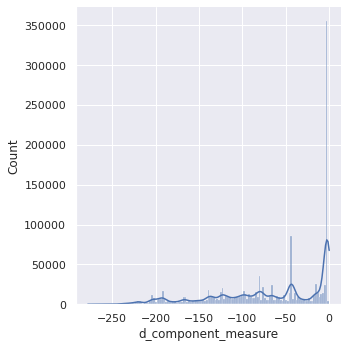

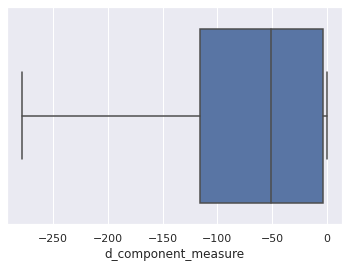

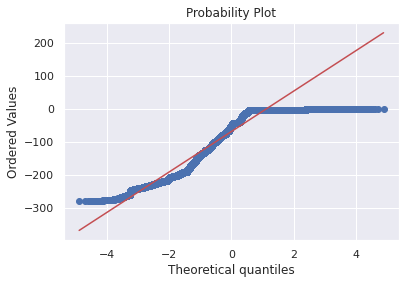

In [30]:
# d-component measurement
plot_variable(dataset['d_component_measure'])

We will reduce the skewness of d-component measurement, as it is left-skewed.

In [31]:
# Applying cube root transformation
dataset['d_component_measure'] = np.cbrt(dataset['d_component_measure'])

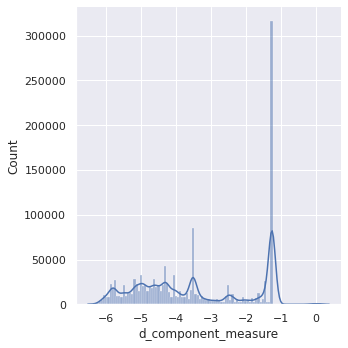

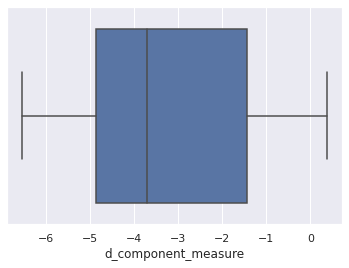

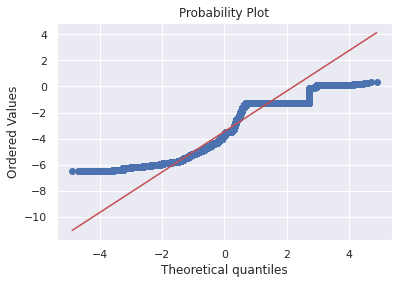

In [32]:
# Visualizing the feature after transformation
plot_variable(dataset['d_component_measure'])

The feature is now following a normal distribution.

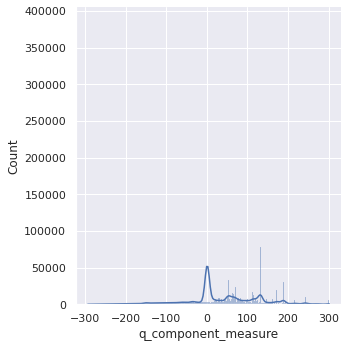

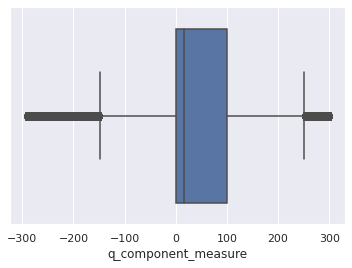

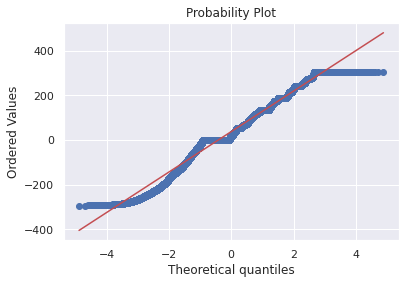

In [33]:
# q-component measurement
plot_variable(dataset['q_component_measure'])

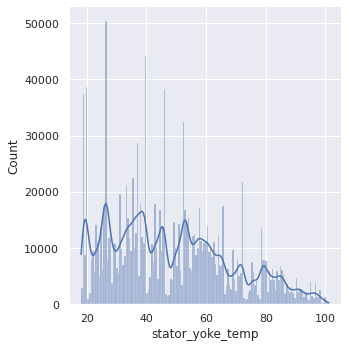

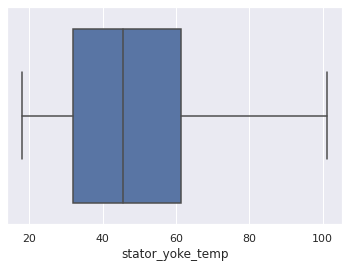

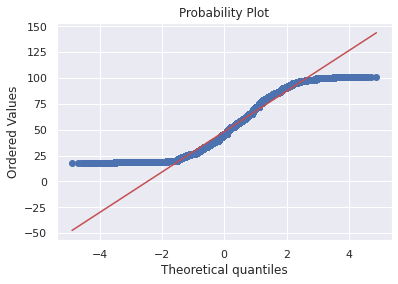

In [34]:
# Stator yoke temperature
plot_variable(dataset['stator_yoke_temp'])

Stator yoke temperature is slightly right skewed(0.481009). Hence we will reduce this skewness.

In [35]:
# Applying box-cox transformation
dataset['stator_yoke_temp'] = stats.boxcox(dataset['stator_yoke_temp'])[0]

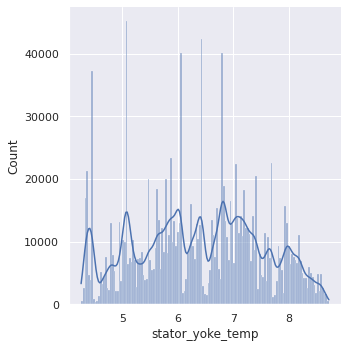

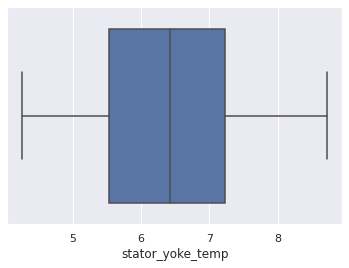

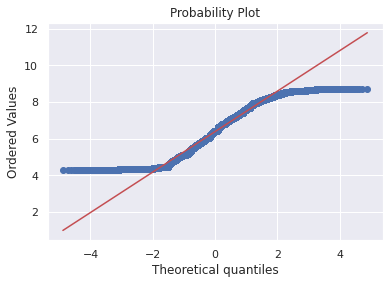

In [36]:
# Visualizing Stator yoke temperature after transformation
plot_variable(dataset['stator_yoke_temp'])

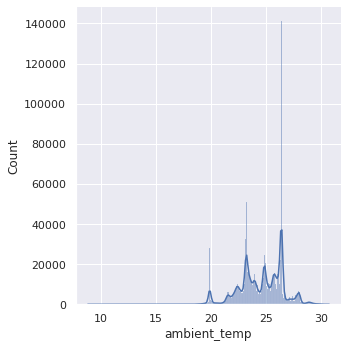

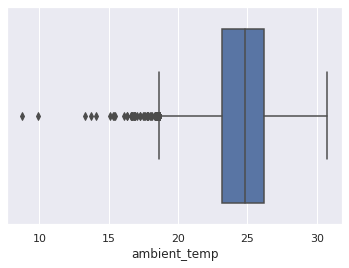

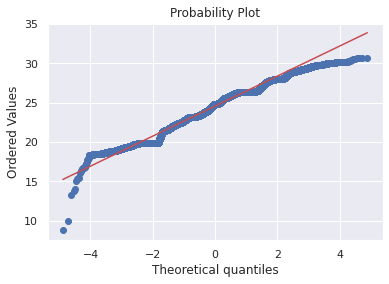

In [37]:
# Ambient temperature
plot_variable(dataset['ambient_temp'])

Ambient temperature is slightly left-skewed(-0.349066). Hence we will reduce its skewness.

In [38]:
# Applying box-cox transformation
dataset['ambient_temp'] = stats.boxcox(dataset['ambient_temp'])[0]

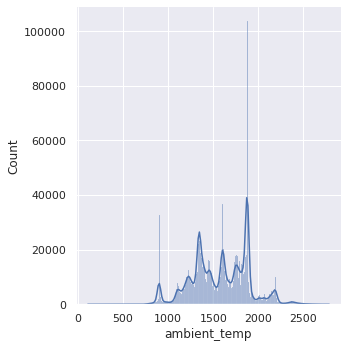

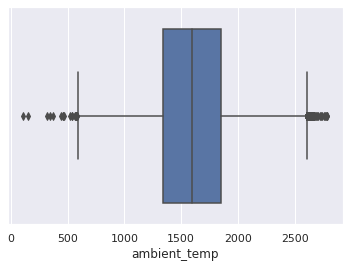

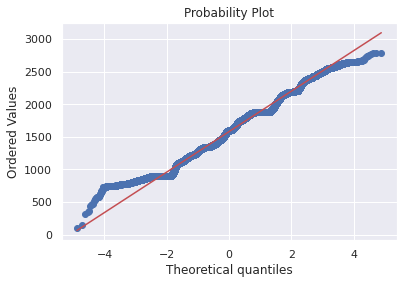

In [39]:
# Visualizing Ambient temperature after transformation
plot_variable(dataset['ambient_temp'])

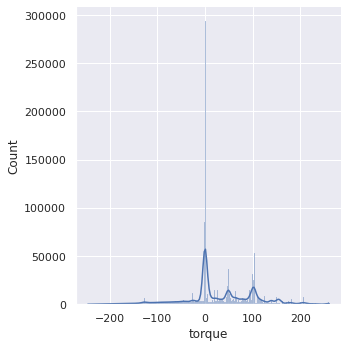

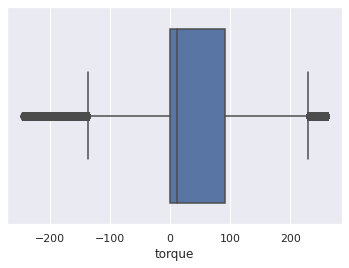

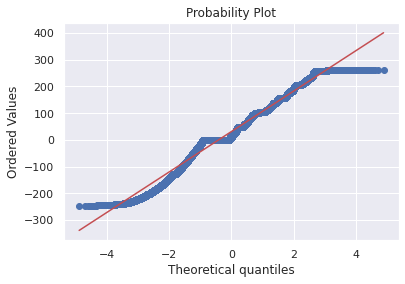

In [40]:
# Motor torque
plot_variable(dataset['torque'])

In [41]:
# Measuring skewness of variables after transformations
dataset.skew()

em_temp                0.038312
q_voltage              0.314933
coolant_temp           0.258110
stator_winding_temp    0.167666
d_voltage              0.145061
stator_tooth_temp      0.137610
motor_speed            0.386464
d_component_measure    0.182256
q_component_measure   -0.146505
stator_yoke_temp      -0.033956
ambient_temp          -0.024709
torque                -0.127141
dtype: float64

All the variables are now following a normal distribution.

In [42]:
# Correlation between variables
correlations = dataset.corr()
correlations

,em_temp,q_voltage,coolant_temp,stator_winding_temp,d_voltage,stator_tooth_temp,motor_speed,d_component_measure,q_component_measure,stator_yoke_temp,ambient_temp,torque
em_temp,1.000000,0.122365,0.479205,0.795893,-0.172031,0.832084,0.458947,-0.382810,-0.142416,0.786494,0.518219,-0.117138
q_voltage,0.122365,1.000000,0.049092,0.050610,0.004702,0.104373,0.683556,-0.276434,-0.124589,0.104690,0.148590,-0.136215
coolant_temp,0.479205,0.049092,1.000000,0.485943,0.230898,0.647398,0.012442,0.040341,-0.300066,0.802550,0.616449,-0.301965
stator_winding_temp,0.795893,0.050610,0.485943,1.000000,-0.234950,0.970135,0.432034,-0.607267,0.065617,0.884667,0.344026,0.095510
d_voltage,-0.172031,0.004702,0.230898,-0.234950,1.000000,-0.142749,-0.288472,0.386629,-0.723069,-0.036473,0.202730,-0.753779
stator_tooth_temp,0.832084,0.104373,0.647398,0.970135,-0.142749,1.000000,0.398431,-0.483021,-0.042294,0.963167,0.452850,-0.018413
motor_speed,0.458947,0.683556,0.012442,0.432034,-0.288472,0.398431,1.000000,-0.720240,-0.068881,0.292652,0.121056,-0.043903
d_component_measure,-0.382810,-0.276434,0.040341,-0.607267,0.386629,-0.483021,-0.720240,1.000000,-0.254248,-0.342842,-0.022780,-0.282643
q_component_measure,-0.142416,-0.124589,-0.300066,0.065617,-0.723069,-0.042294,-0.068881,-0.254248,1.000000,-0.109823,-0.312000,0.996457
stator_yoke_temp,0.786494,0.104690,0.802550,0.884667,-0.036473,0.963167,0.292652,-0.342842,-0.109823,1.000000,0.536895,-0.094136


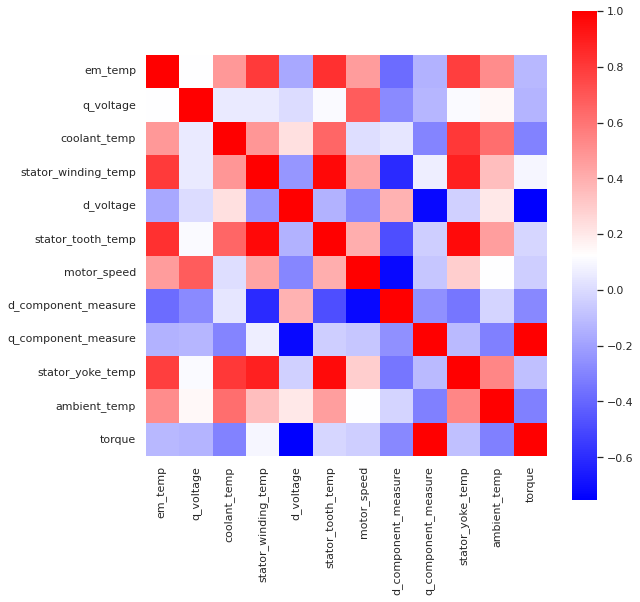

In [43]:
# Heatmap of correlations
plt.figure(figsize=(9,9))
sns.heatmap(correlations, square=True, cmap='bwr')
plt.show()

Keeping 0.8 as threshold, the following pairs of variables are highly correlated:
1. Electric motor temperature, Stator tooth temperature
2. Coolant temperature, Stator yoke temperature
3. Stator winding temperature, Stator tooth temperature
4. Stator winding temperature, Stator yoke temperature
5. Stator tooth temperature, Stator yoke temperature
6. q-component measurement, Motor torque

# Simple Linear Regression

In [44]:
# Total number of rows
m = dataset.shape[0]

In [45]:
# Splitting the dataset into training, cross-validation and test sets
# 60% - Training set
# 20% - Cross-validation set
# 20% - Test set
train, cv, test = np.split(dataset.sample(frac=1, random_state=42), [int(m*0.6), int(m*0.8)])

In [46]:
# Extracting target and features
train_y = train['em_temp']
train_x = train.drop(columns=['em_temp'])

cv_y = cv['em_temp']
cv_x = cv.drop(columns=['em_temp'])

test_y = test['em_temp']
test_x = test.drop(columns=['em_temp'])

In [47]:
# Standarding features
scaler = StandardScaler()

train_x_transformed = scaler.fit_transform(train_x)
cv_x_transformed = scaler.transform(cv_x)
test_x_transformed = scaler.transform(test_x)

In [48]:
# Creating an object of LinearRegression class
lin_reg = LinearRegression()

In [49]:
# Fitting the model
lin_reg.fit(train_x_transformed, train_y)

LinearRegression()

In [50]:
# Intercept
lin_reg.intercept_

58.52678601860811

In [51]:
# Coefficients
lin_reg.coef_

array([ -4.85479129,  -8.77542532,  -9.37740222,  -3.13115877,
        20.05188871,   7.42006187,   4.00121519,   9.29410605,
         7.84473842,   4.82965539, -12.17492241])

In [52]:
# Predicting electric motor temperature for training, cross-validation and test sets
pred_train_y = lin_reg.predict(train_x_transformed)
pred_cv_y = lin_reg.predict(cv_x_transformed)
pred_test_y = lin_reg.predict(test_x_transformed)

In [53]:
# Training error
mse(train_y, pred_train_y)

64.38502348144266

In [54]:
# Cross-validation error
mse(cv_y, pred_cv_y)

64.85770358403528

In [55]:
# Test error
mse(test_y, pred_test_y)

64.54218340453643

As we can observe, the training, cross-validation and test set errors are on a similar scale and are high. This indicates that our fitted model has a high bias problem. In the next part of this notebook, we will try to reduce this bias. We will keep the above error value as a benchmark and try to decrease it further. We will apply the following methods to improve the model:
1. Polynomial Regression
2. Regularization

# Polynomial Regression

In [56]:
# Defining a table that shows the errors of polynomial regression
df_degree_errors = pd.DataFrame({'Degree of Polynomial': np.zeros(10), 'Training Error': np.zeros(10),
                                 'Cross-validation Error': np.zeros(10), 'Test Error': np.zeros(10)})

In [57]:
# We will fit upto 10th degree polynomial for each feature and store the errors in the newly defined errors table
for i in range(10):
    pf = PF((i+1), include_bias=False)
    
    train_x_coolant_temp = pf.fit_transform(train_x[['coolant_temp']])
    train_x_stator_winding_temp = pf.transform(train_x[['stator_winding_temp']])
    train_x_stator_tooth_temp = pf.transform(train_x[['stator_tooth_temp']])
    train_x_motor_speed = pf.transform(train_x[['motor_speed']])
    train_x_stator_yoke_temp = pf.transform(train_x[['stator_yoke_temp']])
    train_x_ambient_temp = pf.transform(train_x[['ambient_temp']])
    train_x_torque = pf.transform(train_x[['torque']])
    train_x_q_voltage = pf.transform(train_x[['q_voltage']])
    train_x_d_voltage = pf.transform(train_x[['d_voltage']])
    train_x_q_component_measure = pf.transform(train_x[['q_component_measure']])
    train_x_d_component_measure = pf.transform(train_x[['d_component_measure']])
    
    cv_x_coolant_temp = pf.transform(cv_x[['coolant_temp']])
    cv_x_stator_winding_temp = pf.transform(cv_x[['stator_winding_temp']])
    cv_x_stator_tooth_temp = pf.transform(cv_x[['stator_tooth_temp']])
    cv_x_motor_speed = pf.transform(cv_x[['motor_speed']])
    cv_x_stator_yoke_temp = pf.transform(cv_x[['stator_yoke_temp']])
    cv_x_ambient_temp = pf.transform(cv_x[['ambient_temp']])
    cv_x_torque = pf.transform(cv_x[['torque']])
    cv_x_q_voltage = pf.transform(cv_x[['q_voltage']])
    cv_x_d_voltage = pf.transform(cv_x[['d_voltage']])
    cv_x_q_component_measure = pf.transform(cv_x[['q_component_measure']])
    cv_x_d_component_measure = pf.transform(cv_x[['d_component_measure']])
    
    test_x_coolant_temp = pf.transform(test_x[['coolant_temp']])
    test_x_stator_winding_temp = pf.transform(test_x[['stator_winding_temp']])
    test_x_stator_tooth_temp = pf.transform(test_x[['stator_tooth_temp']])
    test_x_motor_speed = pf.transform(test_x[['motor_speed']])
    test_x_stator_yoke_temp = pf.transform(test_x[['stator_yoke_temp']])
    test_x_ambient_temp = pf.transform(test_x[['ambient_temp']])
    test_x_torque = pf.transform(test_x[['torque']])
    test_x_q_voltage = pf.transform(test_x[['q_voltage']])
    test_x_d_voltage = pf.transform(test_x[['d_voltage']])
    test_x_q_component_measure = pf.transform(test_x[['q_component_measure']])
    test_x_d_component_measure = pf.transform(test_x[['d_component_measure']])
    
    train_p = np.hstack((train_x_coolant_temp, train_x_stator_winding_temp, train_x_stator_tooth_temp, train_x_motor_speed,
                         train_x_stator_yoke_temp, train_x_ambient_temp, train_x_torque,
                         train_x_q_voltage, train_x_d_voltage, train_x_q_component_measure, train_x_d_component_measure))
    
    cv_p = np.hstack((cv_x_coolant_temp, cv_x_stator_winding_temp, cv_x_stator_tooth_temp, cv_x_motor_speed,
                      cv_x_stator_yoke_temp, cv_x_ambient_temp, cv_x_torque,
                      cv_x_q_voltage, cv_x_d_voltage, cv_x_q_component_measure, cv_x_d_component_measure))
    
    test_p = np.hstack((test_x_coolant_temp, test_x_stator_winding_temp, test_x_stator_tooth_temp, test_x_motor_speed,
                        test_x_stator_yoke_temp, test_x_ambient_temp, test_x_torque,
                        test_x_q_voltage, test_x_d_voltage, test_x_q_component_measure, test_x_d_component_measure))
    
    scaler = StandardScaler()
    train_p_transformed = scaler.fit_transform(train_p)
    cv_p_transformed = scaler.transform(cv_p)
    test_p_transformed = scaler.transform(test_p)
    
    lin_reg = LinearRegression()
    lin_reg.fit(train_p_transformed, train_y)
    
    pred_train_y = lin_reg.predict(train_p_transformed)
    pred_cv_y = lin_reg.predict(cv_p_transformed)
    pred_test_y = lin_reg.predict(test_p_transformed)
    
    train_error = mse(train_y, pred_train_y)
    cv_error = mse(cv_y, pred_cv_y)
    test_error = mse(test_y, pred_test_y)
    
    df_degree_errors.iloc[i,0] = (i+1)
    df_degree_errors.iloc[i,1] = train_error
    df_degree_errors.iloc[i,2] = cv_error
    df_degree_errors.iloc[i,3] = test_error

In [58]:
# Polynomial regression errors table
df_degree_errors

,Degree of Polynomial,Training Error,Cross-validation Error,Test Error
0,1.0,64.385023,64.857704,64.542183
1,2.0,48.552745,48.779685,48.602861
2,3.0,46.172162,46.412637,46.261737
3,4.0,44.879667,45.140253,45.021934
4,5.0,42.455190,43.875245,42.588879
5,6.0,40.908448,42.208413,41.027715
6,7.0,40.193689,40.651406,40.282047
7,8.0,39.347226,41.293241,39.394031
8,9.0,38.741408,66.552117,38.788179
9,10.0,38.057056,57.275066,38.105354


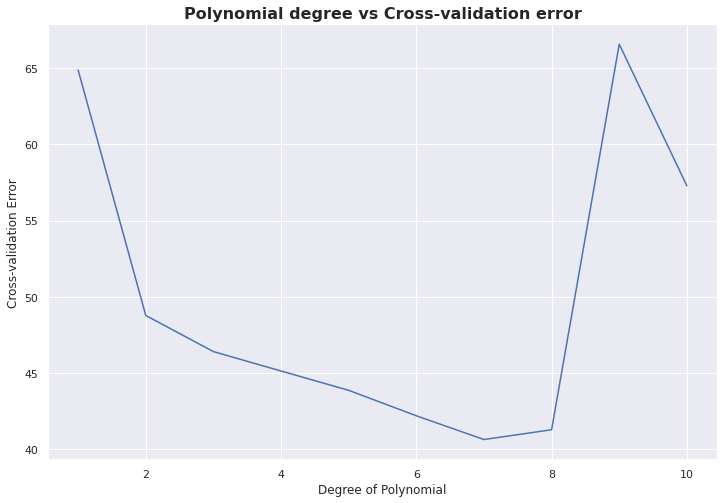

In [59]:
# Plotting Degree of polynomial vs Cross-validation error
plt.figure(figsize=(12,8))
plt.title('Polynomial degree vs Cross-validation error', fontweight='bold', fontsize=16)
plt.xlabel('Degree of Polynomial')
plt.ylabel('Cross-validation Error')
plt.plot(df_degree_errors['Degree of Polynomial'], df_degree_errors['Cross-validation Error'])
plt.show()

As we can observe, the 7th degree polynomial has the lowest error with a value of 40.65, further the training, cross-validation and test set errors are on a similar scale indicating that the model performance is consistent.

All the models before the 7th degree polynomial(1-6) have a high bias problem. All the models after the 7th degree polynomial(8-10) have a high variance problem. The 7th degree polynomial model is just right and is the optimal value for the polynomial degree.

Another observation is wrt the 10th degree polynomial. Although the error drops for the 10th degree polynomial from the 9th degree polynomial, we can see from the errors table that the training, cross-validation and test set errors are at different scales. This indicates that this model may not be consistent wrt performance and it also has high variance. Hence we will not consider examining this model further.

Taking the generalization error (test set error) for the 7th degree polynomial and comparing it to the generalization error of the simple linear regression model, we can see that the model performance has improved by 37.59%!

Next, we will apply Regularization for 7th degree and 8th degree polynomial features and see if we can reduce the error further.

# Regularized Regression

In this section we will be applying linear regression with regularization given by l2-norm, also known as Ridge Regression.

In [60]:
# Defining regularization parameters
# I've derived these regularization parameter values after trying different ranges of values
lambda_values = [0.0000000005, 0.0000000006, 0.0000000007, 0.0000000008, 0.0000000009,
                 0.000000001, 0.000000002, 0.000000003, 0.000000004]

In [61]:
# Regularization parameters list length
lambda_values_len = len(lambda_values)

### 7th degree polynomial

In [62]:
# Defining error results table that shows the errors for different regularization parameters
df_7_regression_error = pd.DataFrame({'Lambda': np.zeros(lambda_values_len), 'Training Error': np.zeros(lambda_values_len),
                                     'Cross-validation Error': np.zeros(lambda_values_len), 'Test Error': np.zeros(lambda_values_len)})

In [63]:
# Creating 7th degree polynomial features
pf = PF(7, include_bias=False)

train_x_coolant_temp = pf.fit_transform(train_x[['coolant_temp']])
train_x_stator_winding_temp = pf.transform(train_x[['stator_winding_temp']])
train_x_stator_tooth_temp = pf.transform(train_x[['stator_tooth_temp']])
train_x_motor_speed = pf.transform(train_x[['motor_speed']])
train_x_stator_yoke_temp = pf.transform(train_x[['stator_yoke_temp']])
train_x_ambient_temp = pf.transform(train_x[['ambient_temp']])
train_x_torque = pf.transform(train_x[['torque']])
train_x_q_voltage = pf.transform(train_x[['q_voltage']])
train_x_d_voltage = pf.transform(train_x[['d_voltage']])
train_x_q_component_measure = pf.transform(train_x[['q_component_measure']])
train_x_d_component_measure = pf.transform(train_x[['d_component_measure']])

cv_x_coolant_temp = pf.transform(cv_x[['coolant_temp']])
cv_x_stator_winding_temp = pf.transform(cv_x[['stator_winding_temp']])
cv_x_stator_tooth_temp = pf.transform(cv_x[['stator_tooth_temp']])
cv_x_motor_speed = pf.transform(cv_x[['motor_speed']])
cv_x_stator_yoke_temp = pf.transform(cv_x[['stator_yoke_temp']])
cv_x_ambient_temp = pf.transform(cv_x[['ambient_temp']])
cv_x_torque = pf.transform(cv_x[['torque']])
cv_x_q_voltage = pf.transform(cv_x[['q_voltage']])
cv_x_d_voltage = pf.transform(cv_x[['d_voltage']])
cv_x_q_component_measure = pf.transform(cv_x[['q_component_measure']])
cv_x_d_component_measure = pf.transform(cv_x[['d_component_measure']])

test_x_coolant_temp = pf.transform(test_x[['coolant_temp']])
test_x_stator_winding_temp = pf.transform(test_x[['stator_winding_temp']])
test_x_stator_tooth_temp = pf.transform(test_x[['stator_tooth_temp']])
test_x_motor_speed = pf.transform(test_x[['motor_speed']])
test_x_stator_yoke_temp = pf.transform(test_x[['stator_yoke_temp']])
test_x_ambient_temp = pf.transform(test_x[['ambient_temp']])
test_x_torque = pf.transform(test_x[['torque']])
test_x_q_voltage = pf.transform(test_x[['q_voltage']])
test_x_d_voltage = pf.transform(test_x[['d_voltage']])
test_x_q_component_measure = pf.transform(test_x[['q_component_measure']])
test_x_d_component_measure = pf.transform(test_x[['d_component_measure']])

train_7 = np.hstack((train_x_coolant_temp, train_x_stator_winding_temp, train_x_stator_tooth_temp,
                     train_x_motor_speed, train_x_stator_yoke_temp, train_x_ambient_temp, train_x_torque,
                     train_x_q_voltage, train_x_d_voltage, train_x_q_component_measure, train_x_d_component_measure))

cv_7 = np.hstack((cv_x_coolant_temp, cv_x_stator_winding_temp, cv_x_stator_tooth_temp, cv_x_motor_speed,
                  cv_x_stator_yoke_temp, cv_x_ambient_temp, cv_x_torque,
                  cv_x_q_voltage, cv_x_d_voltage, cv_x_q_component_measure, cv_x_d_component_measure))

test_7 = np.hstack((test_x_coolant_temp, test_x_stator_winding_temp, test_x_stator_tooth_temp, test_x_motor_speed,
                    test_x_stator_yoke_temp, test_x_ambient_temp, test_x_torque,
                    test_x_q_voltage, test_x_d_voltage, test_x_q_component_measure, test_x_d_component_measure))

scaler = StandardScaler()
train_7_transformed = scaler.fit_transform(train_7)
cv_7_transformed = scaler.transform(cv_7)
test_7_transformed = scaler.transform(test_7)

In [64]:
# Trying different regularization parameters for the 7th degree polynomial features
for i in range(len(lambda_values)):
    ridge_reg = Ridge(lambda_values[i])
    ridge_reg.fit(train_7_transformed, train_y)
    
    pred_train_y = ridge_reg.predict(train_7_transformed)
    pred_cv_y = ridge_reg.predict(cv_7_transformed)
    pred_test_y = ridge_reg.predict(test_7_transformed)
    
    train_error = mse(train_y, pred_train_y)
    cv_error = mse(cv_y, pred_cv_y)
    test_error = mse(test_y, pred_test_y)
    
    df_7_regression_error.iloc[i,0] = lambda_values[i]
    df_7_regression_error.iloc[i,1] = train_error
    df_7_regression_error.iloc[i,2] = cv_error
    df_7_regression_error.iloc[i,3] = test_error

In [65]:
# Error results of different regularization parameters
df_7_regression_error

,Lambda,Training Error,Cross-validation Error,Test Error
0,5.000000e-10,40.454523,40.729282,40.529219
1,6.000000e-10,40.483696,40.747262,40.557447
2,7.000000e-10,40.508740,40.764836,40.581809
3,8.000000e-10,40.530461,40.781435,40.603022
4,9.000000e-10,40.549497,40.796886,40.621669
5,1.000000e-09,40.566344,40.811190,40.638214
6,2.000000e-09,40.670770,40.909719,40.741464
7,3.000000e-09,40.727720,40.967831,40.798169
8,4.000000e-09,40.767886,41.009467,40.838273


Observation: The cross-validation error has not decreased compared to the cross-validation error of 7th degree polynomial features without regularization.

## 8th Order Polynomial

In [66]:
# Defining error results table that shows the errors for different regularization parameters
df_8_regression_error = pd.DataFrame({'Lambda': np.zeros(lambda_values_len), 'Training Error': np.zeros(lambda_values_len),
                                      'Cross-validation Error': np.zeros(lambda_values_len), 'Test Error': np.zeros(lambda_values_len)})

In [67]:
# Creating 8th degree polynomial features
pf = PF(8, include_bias=False)

train_x_coolant_temp = pf.fit_transform(train_x[['coolant_temp']])
train_x_stator_winding_temp = pf.transform(train_x[['stator_winding_temp']])
train_x_stator_tooth_temp = pf.transform(train_x[['stator_tooth_temp']])
train_x_motor_speed = pf.transform(train_x[['motor_speed']])
train_x_stator_yoke_temp = pf.transform(train_x[['stator_yoke_temp']])
train_x_ambient_temp = pf.transform(train_x[['ambient_temp']])
train_x_torque = pf.transform(train_x[['torque']])
train_x_q_voltage = pf.transform(train_x[['q_voltage']])
train_x_d_voltage = pf.transform(train_x[['d_voltage']])
train_x_q_component_measure = pf.transform(train_x[['q_component_measure']])
train_x_d_component_measure = pf.transform(train_x[['d_component_measure']])

cv_x_coolant_temp = pf.transform(cv_x[['coolant_temp']])
cv_x_stator_winding_temp = pf.transform(cv_x[['stator_winding_temp']])
cv_x_stator_tooth_temp = pf.transform(cv_x[['stator_tooth_temp']])
cv_x_motor_speed = pf.transform(cv_x[['motor_speed']])
cv_x_stator_yoke_temp = pf.transform(cv_x[['stator_yoke_temp']])
cv_x_ambient_temp = pf.transform(cv_x[['ambient_temp']])
cv_x_torque = pf.transform(cv_x[['torque']])
cv_x_q_voltage = pf.transform(cv_x[['q_voltage']])
cv_x_d_voltage = pf.transform(cv_x[['d_voltage']])
cv_x_q_component_measure = pf.transform(cv_x[['q_component_measure']])
cv_x_d_component_measure = pf.transform(cv_x[['d_component_measure']])

test_x_coolant_temp = pf.transform(test_x[['coolant_temp']])
test_x_stator_winding_temp = pf.transform(test_x[['stator_winding_temp']])
test_x_stator_tooth_temp = pf.transform(test_x[['stator_tooth_temp']])
test_x_motor_speed = pf.transform(test_x[['motor_speed']])
test_x_stator_yoke_temp = pf.transform(test_x[['stator_yoke_temp']])
test_x_ambient_temp = pf.transform(test_x[['ambient_temp']])
test_x_torque = pf.transform(test_x[['torque']])
test_x_q_voltage = pf.transform(test_x[['q_voltage']])
test_x_d_voltage = pf.transform(test_x[['d_voltage']])
test_x_q_component_measure = pf.transform(test_x[['q_component_measure']])
test_x_d_component_measure = pf.transform(test_x[['d_component_measure']])

train_8 = np.hstack((train_x_coolant_temp, train_x_stator_winding_temp, train_x_stator_tooth_temp,
                     train_x_motor_speed, train_x_stator_yoke_temp, train_x_ambient_temp, train_x_torque,
                     train_x_q_voltage, train_x_d_voltage, train_x_q_component_measure, train_x_d_component_measure))

cv_8 = np.hstack((cv_x_coolant_temp, cv_x_stator_winding_temp, cv_x_stator_tooth_temp, cv_x_motor_speed,
                  cv_x_stator_yoke_temp, cv_x_ambient_temp, cv_x_torque,
                  cv_x_q_voltage, cv_x_d_voltage, cv_x_q_component_measure, cv_x_d_component_measure))

test_8 = np.hstack((test_x_coolant_temp, test_x_stator_winding_temp, test_x_stator_tooth_temp, test_x_motor_speed,
                    test_x_stator_yoke_temp, test_x_ambient_temp, test_x_torque,
                    test_x_q_voltage, test_x_d_voltage, test_x_q_component_measure, test_x_d_component_measure))

scaler = StandardScaler()
train_8_transformed = scaler.fit_transform(train_8)
cv_8_transformed = scaler.transform(cv_8)
test_8_transformed = scaler.transform(test_8)

In [68]:
# Trying different regularization parameters for the 8th degree polynomial features
for i in range(len(lambda_values)):
    ridge_reg = Ridge(lambda_values[i])
    ridge_reg.fit(train_8_transformed, train_y)
    
    pred_train_y = ridge_reg.predict(train_8_transformed)
    pred_cv_y = ridge_reg.predict(cv_8_transformed)
    pred_test_y = ridge_reg.predict(test_8_transformed)
    
    train_error = mse(train_y, pred_train_y)
    cv_error = mse(cv_y, pred_cv_y)
    test_error = mse(test_y, pred_test_y)
    
    df_8_regression_error.iloc[i,0] = lambda_values[i]
    df_8_regression_error.iloc[i,1] = train_error
    df_8_regression_error.iloc[i,2] = cv_error
    df_8_regression_error.iloc[i,3] = test_error

In [69]:
# Error results of different regularization parameters
df_8_regression_error

,Lambda,Training Error,Cross-validation Error,Test Error
0,5.000000e-10,39.605264,40.044268,39.651325
1,6.000000e-10,39.620374,40.038618,39.665077
2,7.000000e-10,39.634405,40.035145,39.677970
3,8.000000e-10,39.647573,40.033420,39.690173
4,9.000000e-10,39.659995,40.033068,39.701771
5,1.000000e-09,39.671746,40.033783,39.712813
6,2.000000e-09,39.761245,40.064469,39.798591
7,3.000000e-09,39.817621,40.099487,39.853678
8,4.000000e-09,39.855876,40.127841,39.891380


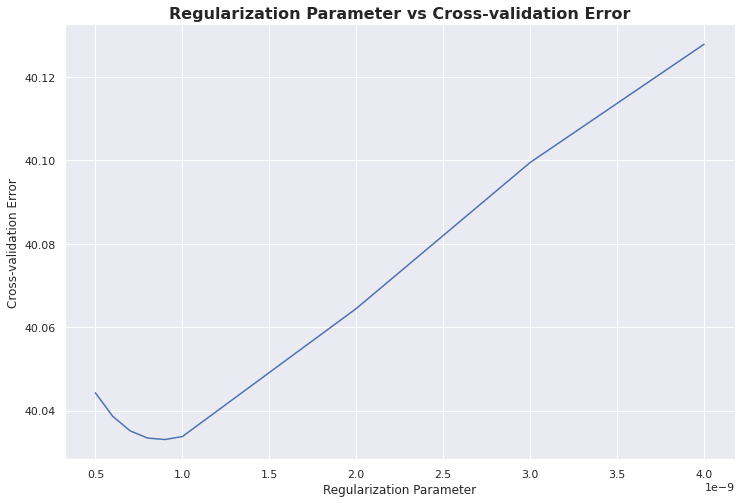

In [70]:
# Plotting Regularization Parameter vs Cross-validation Error
plt.figure(figsize=(12,8))
plt.title('Regularization Parameter vs Cross-validation Error', fontsize=16, fontweight='bold')
plt.xlabel('Regularization Parameter')
plt.ylabel('Cross-validation Error')
plt.plot(df_8_regression_error['Lambda'], df_8_regression_error['Cross-validation Error'])
plt.show()

We can see that for the regularization parameter value of 0.0000000009 for 8th degree polynomial features, the error is least with a value of 40.03, so the error has decreased from the previous 40.65 to 40.03

Further the error of training, cross-validation and test sets are on a similar scale, indicating that the model is consistent wrt performance.

Comparing the generalization error to the generalization error of the 7th degree polynomial features(without regularization), the error has decreased by 1.44%

Hence, we will choose the 8th degree polynomial features with regularization parameter of 0.0000000009 to construct our final model.

# Final Model

In [71]:
# Regularization parameter
lambda_val = 0.0000000009

In [72]:
# Creating an object of Ridge class
ridge_reg = Ridge(lambda_val)

In [73]:
# We already have the standardized 8th degree polynomial features from the previous section.
# The features are stored in "train_8_transformed" variable
# Fitting the final model
ridge_reg.fit(train_8_transformed, train_y)

Ridge(alpha=9e-10)

In [74]:
# Intercept
ridge_reg.intercept_

58.526780499019424

In [75]:
# Coefficients
ridge_reg.coef_

array([-2.75036403e+06,  5.18060854e+06,  1.11422400e+06, -3.63214190e+06,
       -3.53356177e+06,  1.27860093e+06,  5.16992923e+06, -2.82730052e+06,
        1.88136445e+03, -1.44623901e+04,  5.18984514e+04, -1.10557725e+05,
        1.47049742e+05, -1.20019318e+05,  5.49922615e+04, -1.08224217e+04,
       -1.43475686e+03,  1.00158913e+04, -3.10020506e+04,  5.53757435e+04,
       -5.98756454e+04,  3.82685593e+04, -1.29754718e+04,  1.70021167e+03,
       -4.34829226e+00,  8.07515927e+02, -6.05588329e+03,  2.11934409e+04,
       -4.02537472e+04,  4.27063519e+04, -2.38456253e+04,  5.46849807e+03,
        1.13245244e+05, -6.64936257e+05,  1.61872894e+06, -2.03219579e+06,
        1.27392465e+06, -2.18000809e+05, -1.53803008e+05,  6.30167700e+04,
        2.27793676e+02, -1.48365293e+03,  3.97233681e+03, -4.85146530e+03,
        1.41431860e+03,  2.74718848e+03, -2.86019139e+03,  8.36805531e+02,
       -1.08131434e+01, -7.52837492e+01,  3.06158689e+01,  1.01261602e+02,
       -4.85743041e+01, -

In [76]:
# Predicting electric motor temperature for training, cross-validation and test sets
pred_train_y = ridge_reg.predict(train_8_transformed)
pred_cv_y = ridge_reg.predict(cv_8_transformed)
pred_test_y = ridge_reg.predict(test_8_transformed)

In [77]:
# Calculating training, cross-validation and test set errors
train_error = mse(train_y, pred_train_y)
cv_error = mse(cv_y, pred_cv_y)
test_error = mse(test_y, pred_test_y)

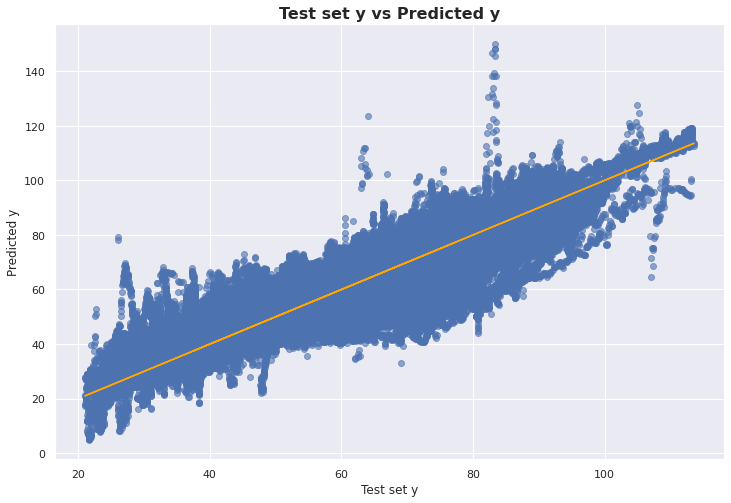

In [78]:
# Plotting test set target vs predicted target
y_hat = test_y
plt.figure(figsize=(12,8))
plt.scatter(test_y, pred_test_y, alpha = 0.6)
plt.title('Test set y vs Predicted y', fontsize=16, fontweight='bold')
plt.xlabel('Test set y')
plt.ylabel('Predicted y')
plt.plot(test_y, y_hat, color='orange', label='model')
plt.show()

In [79]:
# Generalization error
test_error

39.70177090063992

In [80]:
# R-squared value
ridge_reg.score(test_8_transformed, test_y)

0.8900539523877057

With this, we have built a regression model with a generalization error of 39.7 and R-squared of 0.89

Steps we can take to further decrease the error:
1. Instead of having the same degree of polynomial for all the features, we can have different degrees of polynomial for different features.
2. We can try different functions other than polynomials on the features like square-root, exponential etc.